## Imputations methods

In this notebook we are going to explore different imputation methods

For a more theoretical perspective consider http://www.stat.columbia.edu/~gelman/arm/missing.pdf

We are dealing with data probably belonging to the category missing by design (some values are too expensive to obtain)

Also look at https://www.paultwin.com/wp-content/uploads/Lodder_1140873_Paper_Imputation.pdf

TODO: also take into account more complicated methods that directly tackle the problem of classification such as BoostClean https://arxiv.org/pdf/1711.01299.pdf
TODO: also try EM imputation

For a more detail description check the book "Flexible imputationn of missing data" https://stefvanbuuren.name/fimd/


For discriminative models it is more elaborate, since that is not possible. There are a number of approaches. Gharamani and Jordan http://mlg.eng.cam.ac.uk/zoubin/papers/nips93.pdf describe a principled approach, where missing values are treated like hidden variables, and a variant of the EM algorithm is used to estimate them. In a similar fashion, Smola et al. http://www.gatsby.ucl.ac.uk/aistats/fullpapers/234.pdf describe a variant of the SVM algorithm which explicitly tackles the problem.

In out case the missingness of values is not random but can be an indicator by itself

First we need to define a little clearer the setting exactly. For startes we are going to deal with only the 5 most common diseases. Also for starters we are merely going to deal with classifying based on the first diagnosis given only. We are going to consider the multiclass classification problem first, but we are should also check the binary classification one to compare with established methods.

In [1]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

In [2]:
behaviour_data = pd.read_csv('./DataScience2019_MRI/Behavioral/cleaned/HBNFinalSummaries.csv', low_memory=False)

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their evaluation was incomplete.')

keep_most_common_diseases = 5
healthy_diagnosis = 'No Diagnosis Given'

# these disorders should also include the no diagnosis given option
keep_most_common_diseases += 1

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

# count for each disorder number of occurences
disorder_counts = {}
for val in behaviour_data[category_columns].values.reshape(-1):
    if not pd.isnull(val):
        if val in disorder_counts:
            disorder_counts[val] += 1
        else:
            disorder_counts[val] = 1
            
# sort in descending order
disorder_counts = sorted(disorder_counts.items(), key=lambda kv: -kv[1])

most_common_disorders = [x[0] for x in disorder_counts[:keep_most_common_diseases]]

# find users that have no diagnosis within these top diseases 
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col
    
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their diagnoses were very uncommon.')

Removing 282 patients as their evaluation was incomplete.
Removing 37 patients as their diagnoses were very uncommon.


In [3]:
behaviour_data.shape

(1777, 447)

In [4]:
no_diagnosis_given = 'No Diagnosis Given'
most_common_disorders

['Neurodevelopmental Disorders',
 'Anxiety Disorders',
 'Disruptive',
 'No Diagnosis Given',
 'Depressive Disorders',
 'Elimination Disorders']

In [5]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)


df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

Now we can safely remove previous columns describing diagnosis

In [6]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX')!=-1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [7]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

It is also reasonable to assume that we need to drop columns with too many Nans?

In [0]:
# threshold = 0.8

# columns_mask = pd.isnull(behaviour_data).sum() / behaviour_data.shape[0] > threshold

# print('Droping this many columns:', np.sum(columns_mask))

# dropped_columns = behaviour_data.columns[columns_mask]

# behaviour_data = behaviour_data.drop(columns=dropped_columns)
# behaviour_data = behaviour_data.reset_index(drop=True)

In [283]:
print('Shape', behaviour_data.shape)
behaviour_data.head(5)

Shape (1760, 312)


,Anonymized.ID,EID,Sex,Age,Study.Site,ACE_Score,APQ_P_OPD,APQ_P_Total,APQ_SR_OPD,APQ_SR_Total,ARI_P_Total_Score,ARI_S_Total_Score,ASR_Total,ASSQ_Total,AUDIT_Total_Score,Barratt_Total_Edu,Barratt_Total_Occ,Barratt_Total,C3SR_AG,C3SR_FR,C3SR_HY,C3SR_IN,C3SR_NI,C3SR_PI,CAARS_HR_Raw,CAARS_IE_Raw,CAARS_ADHD_Raw,CBCL_AD,CBCL_WD,CBCL_SC,CBCL_RBB,CBCL_AB,CBCL_Int,CBCL_Ext,CBCL_C,CBCL_Total,CBCL_Pre_AB,CBCL_Pre_AD,CBCL_Pre_SC,CBCL_Pre_WD,...,WHODAS_P_Score,WHODAS_SR_Score,WIAT_Num_Raw,WIAT_Pseudo_Raw,WIAT_Spell_Raw,WIAT_Word_Raw,WIAT_LCRV_Raw,WIAT_LCODC_Raw,WIAT_RC_Raw,WIAT_MP_Raw,WISC_BD_Raw,WISC_Similarities_Raw,WISC_MR_Raw,WISC_DS_Raw,WISC_Coding_Raw,WISC_Vocab_Raw,WISC_FW_Raw,WISC_VP_Raw,WISC_PS_Raw,WISC_SS_Raw,WISC_VSI,WISC_VCI,WISC_FRI,WISC_WMI,WISC_PSI,WISC_FSIQ,YSR_AB,YSR_AD,YSR_WD,YSR_RBB,YSR_SC,YSR_Ext,YSR_Int,YSR_Total,Neurodevelopmental Disorders,No Diagnosis Given,Anxiety Disorders,Depressive Disorders,Disruptive,Trauma and Stressor Related Disorders
0,A00078864,NDARYM832PX3,1,7.048254,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1.0,0.0,4.0,14.0,12.0,18.0,28.0,58.0,NaN,NaN,NaN,NaN,...,NaN,NaN,14.0,2.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0,0
1,A00078865,NDARNJ687DMC,1,6.348163,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,21.0,40.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,5.0,1.0,5.0,20.0,19.0,25.0,33.0,77.0,NaN,NaN,NaN,NaN,...,NaN,NaN,9.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0
2,A00078866,NDARRM363BXZ,0,10.052589,1,NaN,NaN,NaN,17.0,118.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,6.0,2.0,14.0,16.0,2.0,2.0,NaN,NaN,NaN,11.0,7.0,14.0,7.0,19.0,32.0,26.0,40.0,98.0,NaN,NaN,NaN,NaN,...,NaN,NaN,29.0,36.0,25.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0
3,A00078867,NDARUW586LLL,1,12.319415,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,9.0,10.0,19.0,4.0,5.0,11.0,17.0,0.0,0.0,NaN,NaN,NaN,16.0,10.0,13.0,3.0,16.0,39.0,19.0,42.0,100.0,NaN,NaN,NaN,NaN,...,NaN,NaN,36.0,18.0,29.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,12.0,8.0,7.0,9.0,16.0,29.0,85.0,0,0,0,1,0,0
4,A00078868,NDARDC298NW4,0,13.901437,1,NaN,NaN,NaN,33.0,154.0,NaN,NaN,NaN,11.0,0.0,NaN,NaN,NaN,2.0,11.0,9.0,12.0,1.0,2.0,NaN,NaN,NaN,3.0,4.0,2.0,4.0,7.0,9.0,11.0,32.0,52.0,NaN,NaN,NaN,NaN,...,NaN,NaN,32.0,26.0,27.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,5.0,2.0,11.0,10.0,26.0,70.0,1,0,0,0,0,0


We are going to explore some different imputation methods. More specifically:
1. Do nothing
2. Fill all missing values with a dummy value
3. Imputation Using (Mean/Median/Most Frequent) Values
4. Imputation Using k-NN, Randomforest
5. MICE (TODO)
6. Multiple imputer
7. Add features based on whether the value exists or not

For a comparison with a more naive baseline check out @gvasilako 's notebook for both multilabel and per class metrics

In [0]:
!pip install missingpy impyute

In [0]:
import sys
import xgboost as xgb
from missingpy import KNNImputer, MissForest
import impyute as impy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning

In [0]:
# fdx and mdx may contain 'No Diagnosis'
# drop them for now but they may be important
# they correspond to father's and mother's primary diagnosis
columns_to_drop = ['Anonymized.ID', 'EID', 'mdx', 'fdx', 'fcodxm_1', 'fcodxm_2', 'fcodxm_3', 'mcodxm_1',
                   'mcodxm_2', 'mcodxm_3', 'mcodxmdt', 'TOWRE_Total_Desc', 'Picture_Vocab_Raw',
                   'sib1dx', 'sib1codxm_1', 'sib1codxm_2', 'sib1codxm_3',
                   'sib2dx', 'sib2codxm_1', 'sib2codxm_2', 'sib2codxm_3',
                   'sib3dx', 'sib3codxm_1', 'sib3codxm_2', 'sib3codxm_3',
                   'sib4dx', 'sib4codxm_1', 'sib4codxm_2', 'sib4codxm_3',
                   'sib5dx', 'sib5codxm_1', 'sib5codxm_2', 'sib5codxm_3']

processed = behaviour_data.drop(columns=columns_to_drop)
most_common_disorders = list(most_common_disorders)

In [0]:
from sklearn.model_selection import KFold
    
def run_binary_classification(dataset, diseases_to_run_for, clf, imputer, imputer_requires_disorder, 
                              drop_missing_threshold, *args):
    
    conf_matrices = []
    for check_disorder in most_common_disorders[:diseases_to_run_for]:
        
        if check_disorder == no_diagnosis_given:
            continue
            
        # only include patients that have that particular disease vs patients that are healthy
        temp = dataset[(dataset[check_disorder] == 1) | (dataset[healthy_diagnosis] == 1)]
        
        pos = most_common_disorders.index(check_disorder)

        columns_to_drop = most_common_disorders[:pos] + most_common_disorders[(pos + 1):]
        temp = temp.drop(columns=columns_to_drop)
        
        if drop_missing_threshold is not None:
            # drop features missing in drop_missing_threshold percent of the time or more
            # The missingpy algorithms to work require that not columsn have more than 80% missing values

            columns_mask = pd.isnull(temp).sum() / temp.shape[0] > drop_missing_threshold

            print('Droping this many columns:', np.sum(columns_mask))

            dropped_columns = temp.columns[columns_mask]

            temp = temp.drop(columns=dropped_columns)
            
        # drop columns that have only Nan values
        temp = temp.dropna(axis=1, how='all')

        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        kf.get_n_splits(temp)

        preds = np.zeros(temp.shape[0])

        for train_index, test_index in kf.split(temp):
            train, test = temp.iloc[train_index], temp.iloc[test_index]   

            all_columns = train.columns.values
            filtered_columns = train.dropna(axis=1, how='all').columns.values

            columns_to_drop = list(set(all_columns) - set(filtered_columns))         
            train = train.drop(columns=columns_to_drop)
            test = test.drop(columns=columns_to_drop)
            
            if imputer_requires_disorder:
                train, test = imputer(train, test, check_disorder, *args)
            else:
                train, test = imputer(train, test, *args)
            
            clf.fit(train.drop(columns=[check_disorder]), train[check_disorder])
            preds[test_index] = clf.predict(test.drop(columns=[check_disorder]))

        print('================================= {0} ================================='.format(check_disorder))

        y_true = temp[check_disorder]
        precision, recall, _, _ = precision_recall_fscore_support(y_true, preds)
        accuracy = accuracy_score(y_true, preds)

        print('accuracy {:.3f} precision {:.3f} {:.3f} recall {:.3f} {:.3f}' \
              .format(accuracy, precision[0], precision[1], recall[0], recall[1]))

        conf = confusion_matrix(y_true, preds)
        print(conf)
        
        conf_matrices.append(conf)
        
    return conf_matrices

Before actually droping columns that cannot be incorporated for the next analysis as they are categorical values, we should check their correlation with the predicted classes!

In [288]:
disorder_corr = np.zeros((len(columns_to_drop) - 2, len(most_common_disorders)))

# the disorder to find the correlation for
for index, disorder in enumerate(most_common_disorders):
    dropped_columns_dataset = behaviour_data[columns_to_drop + [most_common_disorders[index]]]

    # remove the anonymized id and the EID
    for col in dropped_columns_dataset[2:-1]:
        dropped_columns_dataset[col] = dropped_columns_dataset[col].astype('category').cat.codes

    disorder_corr[:, index] = dropped_columns_dataset[dropped_columns_dataset.columns[2:]].corr()[most_common_disorders[index]][:-1].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


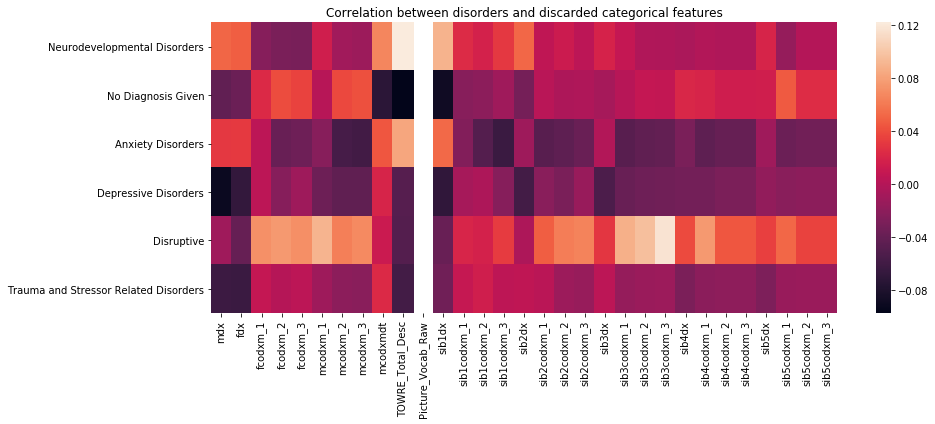

In [289]:
correlation_df = pd.DataFrame(disorder_corr.T, columns=columns_to_drop[2:], index=most_common_disorders)
sns.heatmap(correlation_df)

plt.title('Correlation between disorders and discarded categorical features')
plt.ylim([len(most_common_disorders), 0])
plt.tight_layout()

plt.show()

In [0]:
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100)

### 1st approach: Do nothing

Some algorithms such as XGBoost

In [0]:
def do_nothing(x, y):
    return x, y

run_binary_classification(processed, 1, xgb.XGBClassifier(), do_nothing, False, None)

================================= Neurodevelopmental Disorders =================================
accuracy 0.875 precision 0.614 0.903 recall 0.403 0.956
[[ 27  40]
 [ 17 372]]


### 2nd approach: Fill all missing values with a dummy value 

(For this refer to @gvasilak 's notebook)

### 3rd approach: Imputation Using (Mean/Median/Most_frequent) Values

In [0]:
strategy = 'mean'
assert strategy in ['mean', 'median', 'most_frequent']

def imputer(x, y, strategy):
    if strategy == 'mean':
        filling = x.mean()
    elif strategy == 'median':
        filling = x.median()
    elif strategy == 'most_frequent':
        filling = x.mode().iloc[0]
    
    return x.fillna(filling), y.fillna(filling)

all_matrices_mean = []
for drop_values in np.arange(1, 0, -0.1):
    mean_matrices = run_binary_classification(processed, len(most_common_disorders), clf, imputer, False, drop_values, strategy)
    all_matrices_mean.append(mean_matrices)

### 4th approach: Imputation Using k-NN

The algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. 

In [0]:
threshold = 0.8

columns_mask = pd.isnull(processed).sum() / processed.shape[0] > threshold

print('Droping this many columns:', np.sum(columns_mask))

dropped_columns = processed.columns[columns_mask]

processed = processed.drop(columns=dropped_columns)
processed_80 = processed_80.reset_index(drop=True)

Droping this many columns: 95


In [0]:
def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)

    x[x.columns] = x_new
    y[y.columns] = y_new
    return x, y

my_inputer = KNNImputer(n_neighbors=5, weights="distance")

run_binary_classification(processed_80, 1, clf, imputer_fun, False, 0.8, my_inputer)

Droping this many columns: 1


/home/sotiris/.local/lib/python3.7/site-packages/missingpy/knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
/home/sotiris/.local/lib/python3.7/site-packages/missingpy/knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/home/sotiris/.local/lib/python3.7/site-pa

================================= Neurodevelopmental Disorders =================================
accuracy 0.879 precision 0.650 0.901 recall 0.388 0.964
[[ 26  41]
 [ 14 375]]


In [0]:
def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)

    x[x.columns] = x_new
    y[y.columns] = y_new
    return x, y

my_inputer = MissForest(max_depth=4)

run_binary_classification(processed_80, 1, clf, imputer_fun, False, 0.8, my_inputer)

### 5th approach: MICE

First we can try using EM to complete the missing values!

In [0]:
def imputer_em(x, y, disorder):
    x_values = x.drop(columns=disorder).values
    y_values = y.drop(columns=disorder).values
    total_values = np.concatenate((x_values, y_values), axis=0)

    total_values = impy.em(total_values)

    x.loc[:, x.columns != disorder] = total_values[:x.shape[0]]
    y.loc[:, y.columns != disorder] = total_values[len(total_values) - y.shape[0]:]
    
    return x, y

run_binary_classification(processed_80, 1, clf, imputer_em, True, None)

One of the most popular methods is using MICE. What is the difference between MICE and other multiple imputers?

In [0]:
from fancyimpute import MICE as MICE



## 6th approach: Multiple imputer

In [0]:
from autoimpute.imputations import SingleImputer, MultipleImputer

def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)
    
    return x_new, y_new


si = SingleImputer() # imputation methods, passing through the data once
mi = MultipleImputer() # imputation methods, passing through the data multiple times

run_binary_classification(processed, 1, clf, imputer_fun, False, None, mi)

### 7th approach: Add features indicating if the value os misisng or not

For this part we should take into account which exact features can have Nan values

The features that do not take any null values are 'Sex', 'Age', 'Study.Site' and the disorder we are currently checking for

In [0]:
def process_dataset(x, cols):
    x1 = x.drop(columns=cols).isna().astype('int32')
    
    # change column naming to enable the inner join
    x1.columns = [col + '_existence' for col in x1.columns]
    return x1.join(x)

def data_and_existence_of_features(x, y, disorder):
    cols = ['Sex', 'Age', 'Study.Site', disorder]
    rest_of_columns = list(x.columns.values)
    for c in cols:
        rest_of_columns.remove(c)
    
    x_new = process_dataset(x, cols)
    y_new = process_dataset(y, cols)
    
    x_new[rest_of_columns], y_new[rest_of_columns] = imputer(x_new[rest_of_columns], 
                                                             y_new[rest_of_columns], 
                                                             'most_frequent')
    return x_new, y_new

run_binary_classification(processed, 1, clf, data_and_existence_of_features, True, None)

================================= Neurodevelopmental Disorders =================================
accuracy 0.820 precision 0.739 0.833 recall 0.405 0.954
[[ 51  75]
 [ 18 374]]


## Existence of features

To explore the severity of existence of a feature for the correct classification, we only try to predict based on the existence of the features only and not the actual value

In [0]:
def process_dataset_only_existence(x, cols):
    x1 = x.drop(columns=cols).isna().astype('int32')
    x2 = x[cols]
    
    return x1.join(x2)

def only_existence_of_features(x, y, disorder):
    cols = ['Sex', 'Age', 'Study.Site', disorder]
    return process_dataset_only_existence(x, cols), process_dataset_only_existence(y, cols)

run_binary_classification(processed, 1, clf, only_existence_of_features, True, None)

================================= Neurodevelopmental Disorders =================================
accuracy 0.720 precision 0.398 0.791 recall 0.294 0.857
[[ 37  89]
 [ 56 336]]


## Use an autoencoder as imputation method

Before using an autoencoder we should actually scale the data first!

In [0]:
from sklearn.preprocessing import StandardScaler

layers = [40, 20]
learning_rate = 5
masking=0
dropout=0
regularization = 10.
n_epochs=300

def imputer_autoencoder(x, y, disorder):
    original_x_labels = x[disorder].values
    original_y_labels = y[disorder].values

    data = x.values
    test_data = y.values

    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    test_data = scaler.fit_transform(test_data)

    data_mask = ~np.isnan(data)
    test_data_mask = ~np.isnan(test_data)

    # fill all nan values with a dummy value
    # when using relu activation any negative value should have the same effect
    # also try using the mean value!!
    data[~data_mask] = -1
    test_data[~test_data_mask] = -1
    
    autoencoder = Autoencoder(data.shape[1], layers=layers, masking=masking, regularization=regularization, dropout=dropout)
    autoencoder.fit(data, data_mask, learning_rate=learning_rate, print_every_epochs=1, n_epochs=n_epochs)
    
    reconstructed_data = autoencoder.reconstruct(data)
    data[~data_mask] = reconstructed_data[~data_mask]
    
    reconstructed_test_data = autoencoder.reconstruct(test_data)
    test_data[~test_data_mask] = reconstructed_test_data[~test_data_mask]
    
    x[x.columns] = data
    y[y.columns] = test_data
    x[disorder] = original_x_labels
    y[disorder] = original_y_labels
    return x, y

all_matrices = []
for drop_values in np.arange(1, 0, -0.1):
# for _ in range(2):
    print(drop_values)
    conf_matrices = run_binary_classification(processed, len(most_common_disorders), clf, 
                                              imputer_autoencoder, True, drop_values)
    
    all_matrices.append(conf_matrices)

We can also make predictions based on solely the latent space. This does not seem to work well.

In [0]:
layers = [40, 20]
learning_rate = 5
masking=0
dropout=0
regularization = 10.
n_epochs=300

def imputer_autoencoder_latent(x, y, disorder):
    original_x_labels = x[disorder].values
    original_y_labels = y[disorder].values

    data = x.values
    test_data = y.values

    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    test_data = scaler.fit_transform(test_data)

    data_mask = ~np.isnan(data)
    test_data_mask = ~np.isnan(test_data)

    # fill all nan values with a dummy value
    # when using relu activation any negative value should have the same effect
    # also try using the mean value!!
    data[~data_mask] = -1
    test_data[~test_data_mask] = -1
    
    autoencoder = Autoencoder(data.shape[1], layers=layers, masking=masking, regularization=regularization, dropout=dropout)
    autoencoder.fit(data, data_mask, learning_rate=learning_rate, print_every_epochs=1, n_epochs=n_epochs)
    
    latent_data = autoencoder.get_latent_space(data)
    latent_test_data = autoencoder.get_latent_space(test_data)
    
    data_new = np.concatenate((latent_data, np.expand_dims(original_x_labels, axis=1)), axis=1)
    data_new = pd.DataFrame(data_new, columns=list(range(autoencoder.layers[-1])) + [disorder])    

    data_test_new = np.concatenate((latent_test_data, np.expand_dims(original_y_labels, axis=1)), axis=1)
    data_test_new = pd.DataFrame(data_test_new, columns=list(range(autoencoder.layers[-1])) + [disorder])    

    return data_new, data_test_new

all_matrices = []
for drop_values in np.arange(1, 0, -0.1):
    print(drop_values)
    conf_matrices = run_binary_classification(processed, len(most_common_disorders), clf, 
                                              imputer_autoencoder_latent, True, drop_values)
    
    all_matrices.append(conf_matrices)

## Generative model for imputation of missign values


GAIN seems to be promising: http://medianetlab.ee.ucla.edu/papers/ICML_GAIN.pdf

the introduction in this paper is excelent for different imputation methods

Here try to start also only with columns having values with a threshold regarding the nans in a single column

In [0]:
mask_nans = (np.sum(pd.isnull(processed)) > 0).values
columns_with_nans = processed.columns[mask_nans]

data_nans = processed[columns_with_nans].values
data_nans = data_nans.copy()

In [0]:
import tensorflow as tf

# 1. Mini batch size
mb_size = 8

# 3. Hint rate
p_hint = 0.9

# 4. Loss Hyperparameters/ initial value = 10
alpha = 10

## SHOULD WE SPLIT INTO TRAIN AND TEST SET HERE?

In [0]:
Dim = data_nans.shape[1]

# Hidden state dimensions
H_Dim1 = Dim
H_Dim2 = Dim

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_nans = scaler.fit_transform(data_nans)

In [0]:
missing = np.isnan(data_nans)

In [0]:
data_nans[missing] = 0
missing = 1 - missing.astype(np.int32)

In [0]:
tf.reset_default_graph()

In [0]:
# 1. Xavier Initialization Definition
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape = size, stddev = xavier_stddev)
    
# Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    B = A > p
    C = 1.*B
    return C

#%% GAIN Architecture   
   
#%% 1. Input Placeholders
# 1.1. Data Vector
X = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.2. Mask Vector 
M = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.4. X with missing values
New_X = tf.placeholder(tf.float32, shape = [None, Dim])

#%% 2. Discriminator
D_W1 = tf.Variable(xavier_init([Dim*2, H_Dim1]))     # Data + Hint as inputs
D_b1 = tf.Variable(tf.zeros(shape = [H_Dim1]))

D_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]))
D_b2 = tf.Variable(tf.zeros(shape = [H_Dim2]))

D_W3 = tf.Variable(xavier_init([H_Dim2, Dim]))
D_b3 = tf.Variable(tf.zeros(shape = [Dim]))       # Output is multi-variate

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

#%% 3. Generator
G_W1 = tf.Variable(xavier_init([Dim*2, H_Dim1]))     # Data + Mask as inputs (Random Noises are in Missing Components)
G_b1 = tf.Variable(tf.zeros(shape = [H_Dim1]))

G_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]))
G_b2 = tf.Variable(tf.zeros(shape = [H_Dim2]))

G_W3 = tf.Variable(xavier_init([H_Dim2, Dim]))
G_b3 = tf.Variable(tf.zeros(shape = [Dim]))

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

In [0]:
#%% GAIN Function

#%% 1. Generator
def generator(new_x,m):
    inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
    G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
    
    return G_prob
    
#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)  # [0,1] Probability Output
    
    return D_prob

In [0]:
#%% 3. Other functions
# Random sample generator for Z
def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size = [m, n])        

# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

#%% Structure
# Generator
G_sample = generator(New_X,M)

# Combine with original data
Hat_New_X = New_X * M + G_sample * (1-M)

# Discriminator
D_prob = discriminator(Hat_New_X, H)

#%% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1 + alpha * MSE_train_loss 

In [0]:
#%% Solver
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [0]:
#%% Iterations
#%% Start Iterations
from sklearn.utils import shuffle

def get_batches(iterable, batch_size=16, do_shuffle=True):
    if do_shuffle:
        iterable = shuffle(iterable)

    length = len(iterable)
    for ndx in range(0, length, batch_size):
        iterable_batch = iterable[ndx: min(ndx + batch_size, length)]
        yield iterable_batch

print_every_epochs = 20

sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epochs = 300
for epoch in range(n_epochs):

    for mb_idx in get_batches(range(data_nans.shape[0]), batch_size=mb_size):
        #%% Inputs
        X_mb = data_nans[mb_idx,:]  
        
        Z_mb = sample_Z(len(mb_idx), Dim) 
        M_mb = missing[mb_idx,:]  
        H_mb1 = sample_M(len(mb_idx), Dim, 1-p_hint)
        H_mb = M_mb * H_mb1

        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

        _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
        _, G_loss_curr, MSE_train_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss],
                                                                        feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})
            
    #%% Intermediate Losses
    if epoch % print_every_epochs == 0:
        print('Epoch: {:3d} train_loss {:.4}'.format(epoch, np.sqrt(MSE_train_loss_curr)))

data_reconstructed = np.zeros(data_nans.shape)

# reconstruct
for mb_idx in get_batches(range(data_nans.shape[0]), batch_size=32):
    #%% Inputs
    X_mb = data_nans[mb_idx,:]  
    
    Z_mb = sample_Z(len(mb_idx), Dim) 
    M_mb = missing[mb_idx,:]  
    
    reconstructed = sess.run(G_sample, feed_dict={New_X: X_mb, M: M_mb})
    data_reconstructed[mb_idx] = reconstructed * (1 - M_mb) + X_mb * M_mb

# reconstruct data
data_reconstructed_transformed = scaler.inverse_transform(data_reconstructed)

processed_gan = processed.copy()
processed_gan[columns_with_nans] = data_reconstructed_transformed

def do_nothing(x, y):
    return x, y

conf_matrices_gans = run_binary_classification(processed_gan, len(most_common_disorders), clf, do_nothing, False, None)

conf_matrices_gans = np.array(conf_matrices_gans)

for matrix in conf_matrices_gans:
    print(matrix, matrix[0][0] + matrix[1][1])

## temp

Compare autoencoder confusion matrices with that of the mean imputation techniques

In [58]:
all_matrices_mean = np.array(all_matrices_mean)

for matrix in all_matrices_mean[0]:
    print(matrix, matrix[0][0] + matrix[1][1])

[[  84  151]
 [  27 1256]] 1340
[[162  73]
 [ 42 376]] 538
[[214  21]
 [ 25 145]] 359
[[205  30]
 [ 33 232]] 437
[[225  10]
 [ 43  32]] 257


#### Autoencoder with scaling

layers = [40, 20]
learning_rate = 5
masking=0
dropout=0
regularization = 10.
n_epochs=300


[[array([[  82,  153],
         [  23, 1260]]), array([[161,  74],
         [ 47, 371]]), array([[211,  24],
         [ 24, 146]]), array([[202,  33],
         [ 32, 233]]), array([[224,  11],
         [ 46,  29]])], [array([[  83,  152],
         [  28, 1255]]), array([[163,  72],
         [ 50, 368]]), array([[208,  27],
         [ 22, 148]]), array([[200,  35],
         [ 33, 232]]), array([[223,  12],
         [ 44,  31]])], [array([[  85,  150],
         [  24, 1259]]), array([[162,  73],
         [ 50, 368]]), array([[210,  25],
         [ 21, 149]]), array([[199,  36],
         [ 31, 234]]), array([[224,  11],
         [ 43,  32]])], [array([[  84,  151],
         [  22, 1261]]), array([[162,  73],
         [ 50, 368]]), array([[208,  27],
         [ 24, 146]]), array([[198,  37],
         [ 34, 231]]), array([[226,   9],
         [ 43,  32]])], [array([[  80,  155],
         [  24, 1259]]), array([[157,  78],
         [ 53, 365]]), array([[211,  24],
         [ 21, 149]]), array([[197,  38],
         [ 39, 226]]), array([[224,  11],
         [ 43,  32]])], [array([[  82,  153],
         [  28, 1255]]), array([[163,  72],
         [ 49, 369]]), array([[207,  28],
         [ 23, 147]]), array([[205,  30],
         [ 31, 234]]), array([[225,  10],
         [ 42,  33]])], [array([[  82,  153],
         [  25, 1258]]), array([[158,  77],
         [ 51, 367]]), array([[210,  25],
         [ 29, 141]]), array([[196,  39],
         [ 32, 233]]), array([[224,  11],
         [ 45,  30]])], [array([[  84,  151],
         [  28, 1255]]), array([[161,  74],
         [ 55, 363]]), array([[207,  28],
         [ 25, 145]]), array([[200,  35],
         [ 36, 229]]), array([[222,  13],
         [ 41,  34]])], [array([[  78,  157],
         [  23, 1260]]), array([[156,  79],
         [ 56, 362]]), array([[206,  29],
         [ 31, 139]]), array([[201,  34],
         [ 39, 226]]), array([[221,  14],
         [ 38,  37]])], [array([[  75,  160],
         [ 32, 1251]]), array([[143,  92],
         [ 56, 362]]), array([[201,  34],
         [ 46, 124]]), array([[199,  36],
         [ 34, 231]]), array([[220,  15],
         [ 51,  24]])]]

In [60]:
for i, drop_values in enumerate(np.arange(1, 0.1, -0.1)):
    # print(drop_values)
    accuracies = []
    total = 0
    for matrix in all_matrices_auto[i]:
        # print(matrix, matrix[0][0] + matrix[1][1])
        accuracies.append((matrix[0][0] + matrix[1][1]) / np.sum(matrix))
        total += 1
    
    print(drop_values, np.mean(accuracies))

1.0 0.8532739726016502
0.9 0.8513920187951879
0.8 0.8550480579776772
0.7000000000000001 0.8524009970615187
0.6000000000000001 0.8484328939008092
0.5000000000000001 0.8559595360434548
0.40000000000000013 0.8461487153222731
0.30000000000000016 0.8474948340441173
0.20000000000000018 0.8425589419138639


In [61]:
for i, drop_values in enumerate(np.arange(1, 0.1, -0.1)):
    # print(drop_values)
    accuracies = []
    total = 0
    for matrix in all_matrices_mean[i]:
        # print(matrix, matrix[0][0] + matrix[1][1])
        accuracies.append((matrix[0][0] + matrix[1][1]) / np.sum(matrix))
        total += 1
    
    print(drop_values, np.mean(accuracies))

1.0 0.8592164397543737
0.9 0.8540288265485346
0.8 0.8550816573026061
0.7000000000000001 0.8517290100885427
0.6000000000000001 0.8515769918854869
0.5000000000000001 0.8509142688790089
0.40000000000000013 0.845968761758078
0.30000000000000016 0.8476523128052138
0.20000000000000018 0.8458511641203451
